In [1]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import gc
import cv2
from tqdm import tqdm
tqdm.pandas()
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
TRAIN_ON_KAGGLE = True

In [2]:
sys.path.append("..")

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,Lambda,Dropout,MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose,concatenate
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
from tensorflow.keras.optimizers import Adam

In [4]:
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed=51)

In [5]:
WIDTH = 256
HEIGHT = 256
CHANNELS = 3
#Model Parameters
EPOCHS = 10
BATCH_SIZE = 16

USE_TENSORBOARD = True

In [6]:
input_shape = (WIDTH,HEIGHT,CHANNELS)

In [7]:
from model import get_model
model = get_model(compiling=False)

In [9]:
if TRAIN_ON_KAGGLE:
    h5_file = '../trained_model_kaggle.h5'
    model.load_weights(h5_file)
    adam = Adam(lr = 3e-5)
    model.compile(optimizer = adam, loss = 'mean_squared_error',metrics = [tf.keras.metrics.MeanSquaredError()])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
input_data = np.load('../data/input_data.npy')
target_data = np.load('../data/target_data.npy')

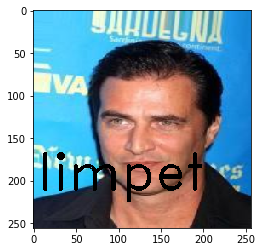

In [12]:
plt.imshow(input_data[10000])

In [13]:
X_test = input_data[20000:]
y_test = target_data[20000:]

input_data = input_data[:20000]
target_data = target_data[:20000]
gc.collect()

7

In [14]:
if TRAIN_ON_KAGGLE == False:
    tf.keras.backend.clear_session()

In [15]:
X_train, X_val, y_train, y_val = train_test_split(input_data, target_data, test_size=0.20, random_state=51)

In [16]:
del input_data,target_data
gc.collect()

10

In [17]:
if USE_TENSORBOARD:
    checkpoint = ModelCheckpoint('../model_epoch_{}.h5'.format(EPOCHS),verbose=1,save_best_only=True)
    early_stopping = EarlyStopping(patience=5,monitor='val_loss')
    tensorboard = TensorBoard(log_dir='../logs')
    callbacks = [checkpoint,early_stopping,tensorboard]
else:
    checkpoint = ModelCheckpoint('../model_epoch_{}.h5'.format(EPOCHS),verbose=1,save_best_only=True)
    early_stopping = EarlyStopping(patience=5,monitor='val_loss')
    callbacks = [checkpoint,early_stopping]

In [18]:
model.fit(x = X_train, y = y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,\
          verbose=1,validation_data=(X_val,y_val),callbacks=callbacks)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
15984/16000 [============================>.] - ETA: 0s - loss: 57.8678 - mean_squared_error: 57.8678
Epoch 00001: val_loss improved from inf to 389.03670, saving model to model_epoch_10.h5
16000/16000 [==============================] - 423s 26ms/sample - loss: 57.8701 - mean_squared_error: 57.8701 - val_loss: 389.0367 - val_mean_squared_error: 389.0366
Epoch 2/10
15984/16000 [============================>.] - ETA: 0s - loss: 55.9868 - mean_squared_error: 55.9867
Epoch 00002: val_loss improved from 389.03670 to 373.40098, saving model to model_epoch_10.h5
16000/16000 [==============================] - 434s 27ms/sample - loss: 55.9801 - mean_squared_error: 55.9800 - val_loss: 373.4010 - val_mean_squared_error: 373.4010
Epoch 3/10
15984/16000 [============================>.] - ETA: 0s - loss: 54.3098 - mean_squared_error: 54.3098
Epoch 00003: val_loss did not improve from 373.40098
16000/16000 [==============================] - 4

In [19]:
val_preds = model.predict(X_val)

In [22]:
np.save('../data/X_train.npy',X_train)
print("="*30)
np.save('../data/y_train.npy',y_train)
print("="*30)
np.save('../data/X_val.npy',X_val)
print("="*30)
np.save('../data/y_val.npy',y_val)
print("="*30)
np.save('../data/X_test.npy',X_test)
print("="*30)
np.save('../data/y_test.npy',y_test)
print("="*30)

In [23]:
val_preds[0].min(),val_preds[0].max()

(1.1279821, 241.64253)

In [24]:
X_val[0].min(),X_val[0].max()

(0, 255)

In [ ]:
for image_no in range(347,367,1):
    plt.subplot(1, 2, 1)
    plt.imshow(X_val[image_no].astype('uint8'))
    plt.subplot(1, 2, 2)
    plt.imshow(val_preds[image_no].astype('uint8'))
    plt.show()